In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 入力ファイルを読み込む
file1 = "IshidaLab_research_project/input_csv_files/binary_protein_data_split_apo_base.csv"  # 1つ目のファイル
file2 = "IshidaLab_research_project/dataset_preprocess/output_csv_files/phase_07/ver_4/max_pocket_rmsd_results1.csv"  # 2つ目のファイル

# CSVデータの読み込み
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

In [3]:
df1_filtered = df1
df2_filtered = df2.loc[df2.groupby(['apo_name', 'apo_chain'])['max_pocket_rmsd'].idxmax()]
#df2_filtered = df2[df2['pocket_id'] == 1]

# 'apo_name', 'apo_chain' が一致する行を1つにまとめる
merged_df = pd.merge(
    df1_filtered[['apo_name', 'apo_chain', 'max_pocket_rmsd']],
    df2_filtered[['apo_name', 'apo_chain', 'max_pocket_rmsd']],
    on=['apo_name', 'apo_chain'],
    suffixes=('_file1', '_file2')  # 列名に接尾辞を追加
)

print(merged_df)

     apo_name apo_chain  max_pocket_rmsd_file1  max_pocket_rmsd_file2
0        2OUV         A               8.522723               8.522723
1        1NNA         A               6.857561               6.857561
2        1O73         A               1.954837               1.954837
3        6NTP         A               9.128823               2.941699
4        3SME         A               8.262643               5.440716
...       ...       ...                    ...                    ...
3040     4DGV         H               7.451132               0.458482
3041     1BVN         P               1.260954               1.260954
3042     6GFL         A               1.116506               1.116506
3043     3QRX         A               1.736334               1.736334
3044     5YB9         A               0.793545               0.793545

[3045 rows x 4 columns]


In [4]:
import os
output_dir = "IshidaLab_research_project/dataset_preprocess/output_csv_files/phase_09/ver_1"
output_csv = os.path.join(output_dir, "max_pocket_rmsd_results1_no_pocket_id.csv")

# 最大値を抽出し、順番を元のデータの順に保つ
df = df2[df2.groupby(['apo_name', 'apo_chain'])['max_pocket_rmsd'].transform('max') == df2['max_pocket_rmsd']]
df.to_csv(output_csv, index=False)

相関係数: 0.65


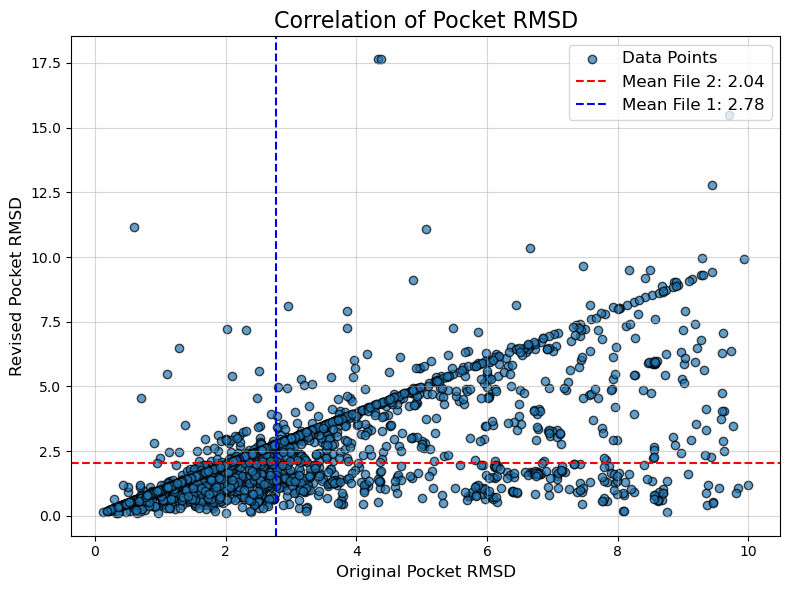

In [5]:
# 列名を明確化
merged_df = merged_df.rename(columns={
    'max_pocket_rmsd_file1': 'file1_pocket_rmsd',
    'max_pocket_rmsd_file2': 'file2_pocket_rmsd'
})
# 欠損値と無限大の値を削除
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['file1_pocket_rmsd', 'file2_pocket_rmsd'])

# pocket_rmsd の相関係数を計算
correlation = merged_df['file1_pocket_rmsd'].corr(merged_df['file2_pocket_rmsd'])

# 相関係数を表示
print(f"相関係数: {correlation:.2f}")

# プロットを作成
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df['file1_pocket_rmsd'], 
    merged_df['file2_pocket_rmsd'], 
    alpha=0.7, edgecolor='k', label='Data Points'
)
plt.title('Correlation of Pocket RMSD', fontsize=16)
plt.xlabel('Original Pocket RMSD', fontsize=12)
plt.ylabel('Revised Pocket RMSD', fontsize=12)
plt.grid(alpha=0.5)

# 平均線を描画
mean_file1 = merged_df['file1_pocket_rmsd'].mean()
mean_file2 = merged_df['file2_pocket_rmsd'].mean()
plt.axhline(y=mean_file2, color='red', linestyle='--', label=f'Mean File 2: {mean_file2:.2f}')
plt.axvline(x=mean_file1, color='blue', linestyle='--', label=f'Mean File 1: {mean_file1:.2f}')
plt.legend(fontsize=12)

plt.tight_layout()

plt.show()

In [6]:
# file1_pocket_rmsdとfile2_pocket_rmsdの値の差を計算
merged_df['rmsd_diff'] = abs(merged_df['file1_pocket_rmsd'] - merged_df['file2_pocket_rmsd'])

# 値の差が大きい順に行を並び替え
sorted_df = merged_df.sort_values(by='rmsd_diff', ascending=False)

# 結果を表示
print(sorted_df.head(10))

     apo_name apo_chain  file1_pocket_rmsd  file2_pocket_rmsd  rmsd_diff
223      1A2W         A           4.327419          17.649860  13.322441
1513     7SC2         A           4.382237          17.645643  13.263406
1798     6T36         A           0.589745          11.167200  10.577455
857      3K7P         A           9.453335           0.504052   8.949283
856      3M1P         A           9.366383           0.425323   8.941060
2926     1NH7         A           9.810024           0.886380   8.923644
855      3K7O         A           9.462106           0.542745   8.919360
2981     6NN6         K           9.990220           1.213021   8.777199
63       1GYJ         A           9.842990           1.097481   8.745509
2876     2NQO         A           8.755654           0.140482   8.615173


In [7]:
# プロットを保存
output_plot = "pocket_rmsd_correlation.png"
plt.savefig(output_plot, dpi=300)
plt.close()

In [8]:
print(len(df))
# max_pocket_rmsdがinfでない行をフィルタリング
non_inf_rows = df[df['max_pocket_rmsd'] != np.inf]
print(f"max_pocket_rmsdがinfでない行の数: {len(non_inf_rows)}")

# max_pocket_rmsdがinfの行を表示
inf_rows = df[df['max_pocket_rmsd'] == np.inf]
print("max_pocket_rmsdがinfの行:")
print(inf_rows)

# max_pocket_rmsdの値が10以下の行をフィルタリング
rows_below_10 = non_inf_rows[non_inf_rows['max_pocket_rmsd'] <= 10]
rows_upper_10 = non_inf_rows[non_inf_rows['max_pocket_rmsd'] > 10]
print(f"max_pocket_rmsdの値が10以下の行の数: {len(rows_below_10)}")

3764
max_pocket_rmsdがinfでない行の数: 3760
max_pocket_rmsdがinfの行:
     apo_name apo_chain holo_name holo_chain  pocket_id  max_pocket_rmsd  \
174      1XAS         A      1v0k          A          1              inf   
408      1HLA         A      6d78          A          1              inf   
2008     1GRL         A      1dkd          A          1              inf   
2080     3C9V         A      1dkd          A          1              inf   

                                             pocket_com  protein_id ligand  \
174                                           [0, 0, 0]         126    XYP   
408   [3.9004556274414064, -10.611964797973632, 9.00...         300    NaN   
2008  [-23.59055519104004, -16.09806489944458, 1.041...         999    NaN   
2080  [-6.238846063613892, -11.792579650878906, 14.1...         999    NaN   

      ligand_atom_count  
174                   9  
408                   0  
2008                  0  
2080                  0  
max_pocket_rmsdの値が10以下の行の数: 3630
